In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [29]:
from tensorflow import keras

# Data

In [7]:
X = np.linspace(0,50,501)

In [8]:
y = np.sin(X)

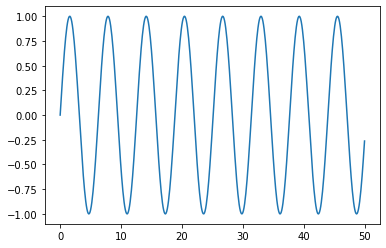

In [9]:
plt.plot(x,y)

In [10]:
 df = pd.DataFrame(data = y, index = x, columns = ['sin'])

In [11]:
train = df.iloc[:int(len(df)*0.9)]

In [12]:
test  = df.iloc[int(len(df)*0.9):]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler()

In [16]:
scaled_train = scaler.transform(train)

In [17]:
scaled_test = scaler.transform(test)

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module tensorflow.python.keras.preprocessing.sequence:

class TimeseriesGenerator(keras_preprocessing.sequence.TimeseriesGenerator, tensorflow.python.keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  # Arguments
 |      data: Indexable generator (such as list or Numpy array)
 |          containing consecutive data points (timesteps).
 |          The data should be at 2D, and axis 0 is expected
 |          to be the time dimension.
 |      targets: Targets corresponding to timesteps in `data`.
 |          It should have same length as `data`.
 | 

In [24]:
length = 25
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [25]:
len(scaled_train)

450

In [26]:
len(generator)

425

In [27]:
generator[0]

(array([[[0.49999912],
         [0.54991622],
         [0.59933458],
         [0.64776041],
         [0.69470985],
         [0.73971381],
         [0.78232262],
         [0.82211054],
         [0.85868004],
         [0.89166571],
         [0.92073798],
         [0.94560637],
         [0.9660224 ],
         [0.98178208],
         [0.99272794],
         [0.99875061],
         [0.99978993],
         [0.9958355 ],
         [0.98692684],
         [0.97315296],
         [0.95465148],
         [0.93160726],
         [0.90425056],
         [0.87285471],
         [0.83773342]]]),
 array([[0.79923759]]))

In [31]:
n_features = 1

# Model

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape = (length, n_features)),
    keras.layers.Dense(1)
])

In [33]:
model.compile(optimizer = 'adam', loss = 'mse')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit_generator(generator, epochs = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 425 steps
Epoch 1/10
425/425 [==============================] - 5s 12ms/step - loss: 0.0032
Epoch 2/10
425/425 [==============================] - 4s 10ms/step - loss: 3.8390e-04
Epoch 3/10
425/425 [==============================] - 4s 10ms/step - loss: 2.7744e-04: 0s - loss
Epoch 4/10
425/425 [==============================] - 4s 10ms/step - loss: 8.4397e-05
Epoch 5/10
425/425 [==============================] - 4s 10ms/step - loss: 1.2322e-04
Epoch 6/10
425/425 [==============================] - 4s 10ms/step - loss: 2.4441e-04
Epoch 7/10
425/425 [==============================] - 4s 10ms/step - loss: 4.7518e-05
Epoch 8/10
425/425 [==============================] - 4s 10ms/step - loss: 4.1577e-04
Epoch 9/10
425/425 [==============================] - 4s 10ms/step - loss: 4.6353e-05
Epoch 10/10
425/425 [==============================] - 4s 10ms/step - loss: 1.2702e-05


In [37]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

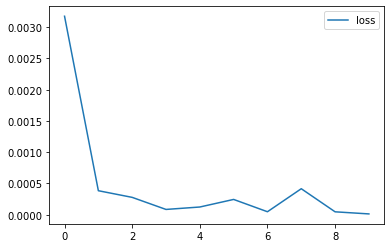

In [38]:
losses.plot()

In [39]:
first_eval_batch = scaled_train[-length:]

In [40]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [41]:
model.predict(first_eval_batch)

array([[0.92262083]], dtype=float32)

In [42]:
scaled_test[0]

array([0.92545429])

In [46]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [50]:
true_pred = scaler.inverse_transform(test_predictions)

In [52]:
test['pred'] = true_pred

C:\Users\dixq1\anaconda3\envs\exam_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

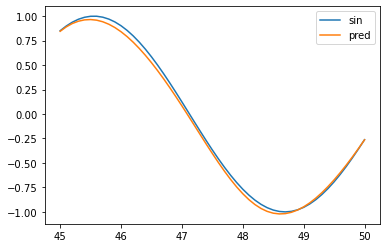

In [53]:
test.plot()

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience = 2)

In [56]:
validator_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=batch_size)

In [62]:
model_2 = keras.models.Sequential([
    keras.layers.LSTM(50, input_shape=(length, n_features)),
    keras.layers.Dense(1)
])

In [63]:
model_2.compile(optimizer = 'adam', loss = 'mse')

In [64]:
model_2.fit_generator(generator, epochs = 20, validation_data = validator_generator, callbacks = [early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 425 steps, validate for 26 steps
Epoch 1/20
425/425 [==============================] - 3s 7ms/step - loss: 0.0128 - val_loss: 3.3176e-05
Epoch 2/20
425/425 [==============================] - 1s 3ms/step - loss: 1.3731e-04 - val_loss: 4.4668e-05
Epoch 3/20
425/425 [==============================] - 1s 3ms/step - loss: 8.8114e-05 - val_loss: 1.9496e-05
Epoch 4/20
425/425 [==============================] - 1s 3ms/step - loss: 5.8490e-04 - val_loss: 4.3011e-05
Epoch 5/20
425/425 [==============================] - 1s 3ms/step - loss: 5.0983e-05 - val_loss: 2.2415e-05


In [65]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    current_pred = model_2.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [66]:
true_pred = scaler.inverse_transform(test_predictions)

In [67]:
test['pred_2'] = true_pred

C:\Users\dixq1\anaconda3\envs\exam_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

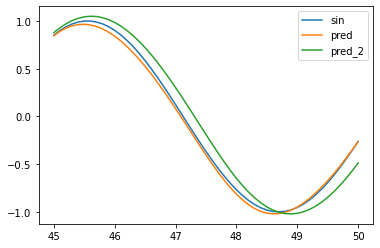

In [68]:
test.plot()